Epoch [1/30], Loss: 13.7235
Epoch [2/30], Loss: 7.5661
Epoch [3/30], Loss: 3.2811
Epoch [4/30], Loss: 3.0868
Epoch [5/30], Loss: 2.9975
Epoch [6/30], Loss: 2.8731
Epoch [7/30], Loss: 2.7255
Epoch [8/30], Loss: 2.6180
Epoch [9/30], Loss: 2.5374
Epoch [10/30], Loss: 2.4809
Epoch [11/30], Loss: 2.4789
Epoch [12/30], Loss: 2.4191
Epoch [13/30], Loss: 2.3742
Epoch [14/30], Loss: 2.3372
Epoch [15/30], Loss: 2.3560
Epoch [16/30], Loss: 2.3864
Epoch [17/30], Loss: 2.3012
Epoch [18/30], Loss: 2.2778
Epoch [19/30], Loss: 2.2757
Epoch [20/30], Loss: 2.2470
Epoch [21/30], Loss: 2.2362
Epoch [22/30], Loss: 2.2095
Epoch [23/30], Loss: 2.1851
Epoch [24/30], Loss: 2.1999
Epoch [25/30], Loss: 2.1917
Epoch [26/30], Loss: 2.1701
Epoch [27/30], Loss: 2.1410
Epoch [28/30], Loss: 2.1537
Epoch [29/30], Loss: 2.1413
Epoch [30/30], Loss: 2.1140


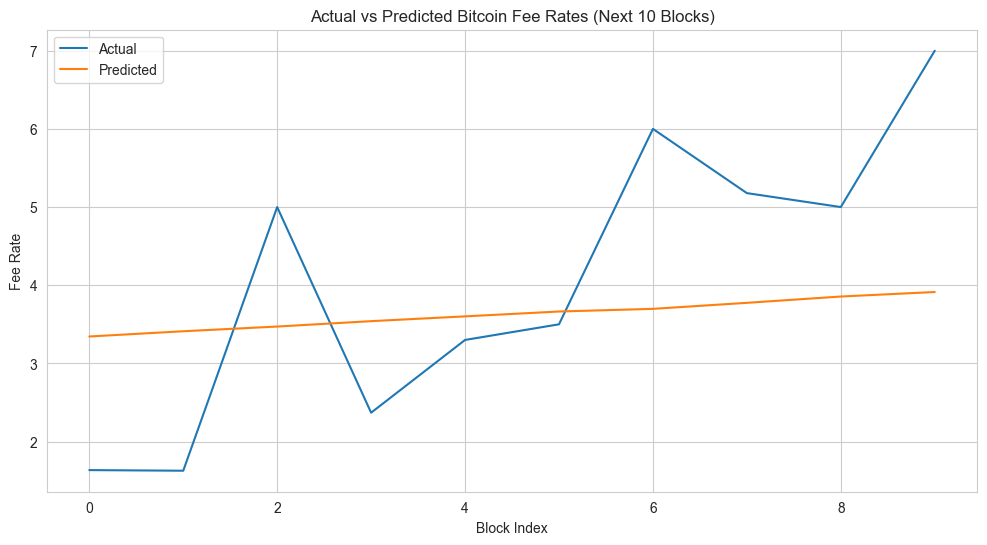


Prophet Model Performance for Next 10 Blocks:
Mean Absolute Error: 1.4596
Mean Squared Error: 2.8039
Root Mean Squared Error: 1.6745
R-squared Score: 0.09479987215629082
MAPE: 44.0497%
Directional Accuracy: 55.5556%
Theil's U Statistic: 0.4285
Training time: 88.6365909576416s


In [30]:
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random

start=time.time()
# Set a fixed seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function to set the seed
set_seed(42)

# Load and preprocess data
df = pd.read_csv('real_time_cleaned.csv')
df['block_time'] = pd.to_datetime(df['block_time'])
df = df.sort_values('block_time')

# Feature Selection (excluding 'mempool_fee_histogram')
features = [
    'block_height', 'tx_count', 'mempool_size_mb', 'max_fee_rate', 'avg_fee_rate',
    'median_fee_rate', 'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std',
    'difficulty', 'hash_rate', 'mempool_min_fee', 'total_fee', 'mempool_usage',
    'transaction_count', 'block_weight', 'block_version', 'block_interval',
    'bitcoin_price_usd', 'hist_low_fee_ratio',
    'hist_med_fee_ratio', 'hist_high_fee_ratio', 'hist_fee_diversity'
]

future_known_features=['block_height',
 'difficulty',
 'hash_rate',
 'bitcoin_price_usd',
 'block_version']

historical_features=['tx_count', 'mempool_size_mb','max_fee_rate',
 'avg_fee_rate',
 'median_fee_rate',
 'fee_rate_10th',
 'fee_rate_90th',
 'fee_rate_std',
 'mempool_min_fee',
 'total_fee',
 'mempool_usage',
 'transaction_count',
 'block_weight',
 'block_interval',
 'hist_low_fee_ratio',
 'hist_med_fee_ratio',
 'hist_high_fee_ratio',
 'hist_fee_diversity']

# Scaling selected features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Prepare data for predicting the next 10 blocks
df['time_idx'] = (df['block_time'] - df['block_time'].min()).dt.total_seconds() // 600  # 10-minute intervals
df['time_idx'] = df['time_idx'].astype(int)  # Ensure time_idx is of type integer

target = 'block_median_fee_rate'
max_encoder_length = 144  # Past 144 observations (24 hours)
max_prediction_length = 10  # Predict next 10 blocks (100 minutes)

# Time2Vec layer
class Time2Vec(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Time2Vec, self).__init__()
        self.w0 = nn.parameter.Parameter(torch.randn(input_dim, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(input_dim, output_dim-1))
        self.b = nn.parameter.Parameter(torch.randn(output_dim-1))
        self.f = torch.sin

    def forward(self, x):
        v1 = torch.matmul(x, self.w0) + self.b0
        v2 = self.f(torch.matmul(x, self.w) + self.b)
        return torch.cat([v1, v2], -1)

# Define custom dataset
class Time2VecDataset(Dataset):
    def __init__(self, data, historical_features, future_known_features, target, max_encoder_length, max_prediction_length):
        self.data = data
        self.historical_features = historical_features
        self.future_known_features = future_known_features
        self.target = target
        self.max_encoder_length = max_encoder_length
        self.max_prediction_length = max_prediction_length

    def __len__(self):
        return len(self.data) - self.max_encoder_length - self.max_prediction_length + 1

    def __getitem__(self, idx):
        encoder_start = idx
        encoder_end = idx + self.max_encoder_length
        decoder_end = encoder_end + self.max_prediction_length

        historical_data = self.data.iloc[encoder_start:encoder_end][self.historical_features]
        future_known_data = self.data.iloc[encoder_end:decoder_end][self.future_known_features]
        target_values = self.data.iloc[encoder_end:decoder_end][self.target]

        # Create time feature (assuming each step is 10 minutes apart)
        time_feature = torch.arange(0, self.max_encoder_length, dtype=torch.float32).unsqueeze(1)

        x_hist = torch.tensor(historical_data.values, dtype=torch.float)
        x_future = torch.tensor(future_known_data.values, dtype=torch.float)
        y = torch.tensor(target_values.values, dtype=torch.float)

        return time_feature, x_hist, x_future, y

# Create dataset and dataloaders
dataset = Time2VecDataset(df, historical_features, future_known_features, target, max_encoder_length, max_prediction_length)
batch_size = 32
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Define updated model
class BitcoinFeeModel(nn.Module):
    def __init__(self, hist_input_dim, future_input_dim, time2vec_dim, hidden_dim, output_dim, num_predictions):
        super(BitcoinFeeModel, self).__init__()
        self.time2vec = Time2Vec(1, time2vec_dim)
        self.lstm = nn.LSTM(hist_input_dim + time2vec_dim, hidden_dim, batch_first=True)
        self.fc_combine = nn.Linear(hidden_dim + future_input_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.num_predictions = num_predictions

    def forward(self, time_feature, x_hist, x_future):
        batch_size, seq_len, _ = x_hist.shape
        time_encoded = self.time2vec(time_feature).expand(batch_size, seq_len, -1)
        x_hist_time = torch.cat([x_hist, time_encoded], dim=-1)
        
        _, (h_n, _) = self.lstm(x_hist_time)
        h_n = h_n.squeeze(0)
        
        outputs = []
        for i in range(self.num_predictions):
            combined = torch.cat((h_n, x_future[:, i, :]), dim=1)
            hidden = self.fc_combine(combined)
            out = self.fc_out(hidden)
            outputs.append(out)
        
        return torch.cat(outputs, dim=1)

# Model parameters
hist_input_dim = len(historical_features)
future_input_dim = len(future_known_features)
time2vec_dim = 16
hidden_dim = 64
output_dim = 1
num_predictions = max_prediction_length

# Instantiate model, loss function, and optimizer
model = BitcoinFeeModel(hist_input_dim, future_input_dim, time2vec_dim, hidden_dim, output_dim, num_predictions)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 30 
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for time_feature, x_hist, x_future, y in train_dataloader:
        time_feature, x_hist, x_future, y = time_feature.to(device), x_hist.to(device), x_future.to(device), y.to(device)

        # Forward pass
        outputs = model(time_feature, x_hist, x_future)
        loss = criterion(outputs, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Make future predictions
def predict_future(model, data, historical_features, future_known_features, max_encoder_length, max_prediction_length):
    model.eval()
    hist_data = data.tail(max_encoder_length)[historical_features].values
    last_block_height = data['block_height'].iloc[-1]
    
    future_data = data.tail(max_prediction_length)[future_known_features].values
    for i in range(max_prediction_length):
        future_data[i, future_known_features.index('block_height')] = last_block_height + i + 1
    
    time_feature = torch.arange(0, max_encoder_length, dtype=torch.float32).unsqueeze(1).to(device)
    x_hist = torch.tensor(hist_data, dtype=torch.float).unsqueeze(0).to(device)
    x_future = torch.tensor(future_data, dtype=torch.float).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(time_feature, x_hist, x_future).cpu().numpy().flatten()

    return predictions

# Predict next 10 blocks
future_predictions = predict_future(model, df, historical_features, future_known_features, max_encoder_length, max_prediction_length)

# Plot results
plt.figure(figsize=(12, 6))
y_true = df[target].iloc[-max_prediction_length:].values
plt.plot(range(len(y_true)), y_true, label='Actual')
plt.plot(range(len(future_predictions)), future_predictions, label='Predicted')
plt.title('Actual vs Predicted Bitcoin Fee Rates (Next 10 Blocks)')
plt.xlabel('Block Index')
plt.ylabel('Fee Rate')
plt.legend()
plt.show()

# Calculate performance metrics
mae = mean_absolute_error(y_true, future_predictions)
mse = mean_squared_error(y_true, future_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, future_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def directional_accuracy(y_true, y_pred):
    return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100

def theil_u(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the percent changes
    y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
    y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]  # Use y_true[:-1] as the base for both
    
    # Calculate Theil's U statistic
    numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct)**2))
    denominator = np.sqrt(np.mean(y_true_pct**2)) + np.sqrt(np.mean(y_pred_pct**2))
    
    return numerator / denominator


mape = mean_absolute_percentage_error(y_true, future_predictions)
da = directional_accuracy(y_true, future_predictions)
theils_u = theil_u(y_true, future_predictions)
end=time.time()

print("\nProphet Model Performance for Next 10 Blocks:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2}")
print(f"MAPE: {mape:.4f}%")
print(f"Directional Accuracy: {da:.4f}%")
print(f"Theil's U Statistic: {theils_u:.4f}")
print(f"Training time: {end-start}s")